# Assignment 2: Voting Visualized

## Deadline

Oct. 24th

## Important notes

- Make sure you push on GitHub your notebook with all the cells already evaluated.
- Note that maps do not render in a standard Github environment. You should export them to HTML and link them in your notebook.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented.
- Please write all your comments in English, and use meaningful variable names in your code.
- Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything. 

## Background


* Are you curious to know what the political leanings of the people of Switzerland are?
* Do you wake up in a cold sweat, wondering which party won the last cantonal parliament election in Vaud?
* Are you looking to learn all sorts of visualizations, including maps, in Python?

If your answer to any of the above is yes, this assignment is just right for you. Otherwise, it's still an assignment, so we're terribly sorry.

The chief aim of this assignment is to familiarize you with visualizations in Python, particularly maps, and also to give you some insight into how visualizations are to be interpreted. The data we will use is the data on Swiss cantonal parliament elections from 2007 to 2018, which contains, for each cantonal election in this time period, the voting percentages for each party and canton.

For the visualization part, install [Folium](Folium) (_Hint: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!_). Folium's README comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find one TopoJSON file, containing the geo-coordinates of the cantonal borders of Switzerland.

One last, general reminder: back up any hypotheses and claims with data, since this is an important aspect of the course.

In [146]:
# Put your imports here.
import pandas as pd
import folium
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
data_folder = './data/'

cantons = pd.read_csv(data_folder + "cantons.csv")

json_file = r'ch-cantons.topojson.json'
ch_cantons = json.load(open(data_folder + json_file))

communes_pop = pd.read_excel(data_folder + "communes_pop.xls")
national_council = pd.read_excel(data_folder + "national_council_elections.xlsx")
voters_xls = pd.ExcelFile(data_folder + 'voters.xls')

In [150]:
swizterland_cood = [46.8182, 8.2275]

## Task 1: Cartography and census

__A)__ Display a Swiss map that has cantonal borders as well as the national borders. We provide a TopoJSON `data/ch-cantons.topojson.json` that contains the borders of the cantons.

__B)__ Take the spreadsheet `data/communes_pop.xls`, collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/catalogues-banques-donnees/tableaux.assetdetail.5886191.html), containing population figures for every commune. You can use [pd.read_excel()](https://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.read_excel.html) to read the file and to select specific sheets. Plot a histogram of the population counts and explain your observations. Do not use a log-scale plot for now. What does this histogram tell you about urban and rural communes in Switzerland? Are there any clear outliers on either side, and if so, which communes?

__C)__ The figure below represents 4 types of histogram. At this stage, our distribution should look like Fig.(a). A common way to represent [power-laws](https://en.wikipedia.org/wiki/Power_law) is to use a histogram using a log-log scale  -- remember: the x-axis of an histogram is segmented in bins of equal sizes and y-values are the average of each bin. As shown in Fig.(b), small bins sizes might introduce artifacts. Fig.(b) and Fig.(c) are examples of histograms with two different bin sizes. Another great way to visualize such distribution is to use a cumulative representation, as show in Fig.(d), in which the y-axis represents the number of data points with values greater than y.  
  
Create the figures (b) and (d) using the data extracted for task 1B. For Fig.(b), represent two histograms using two different bin sizes and provide a brief description of the results. What does this tell you about the relationship between the two variables, namely the frequency of each bin and the value (i.e. population in case of the communal data) for each bin?

<img src="plaw_crop.png" style="width: 600px;">
  
The figure is extracted from [this paper](https://arxiv.org/pdf/cond-mat/0412004.pdf) that contains more information about this family of distributions.

In [151]:
canton_map = folium.Map(location=swizterland_cood,
                   tiles='Mapbox Bright', zoom_start=8)

folium.TopoJson(
    ch_cantons,
    'objects.cantons',
    name='topojson'
).add_to(canton_map)

canton_map

## Task 2: Parties visualized

We provide a spreadsheet, `data/voters.xls`, (again) collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/force-partis.assetdetail.217195.html), which contains the percentage of voters for each party and for each canton. For the following task, we will focus on the period 2014-2018 (the first page of the spreadsheet). Please report any assumptions you make regarding outliers, missing values, etc. Notice that data is missing for two cantons, namely Appenzell Ausserrhoden and Graubünden, and your visualisations should include data for every other canton.


__A)__ For the period 2014-2018 and for each canton, visualize, on the map, **the percentage of voters** in that canton who voted for the party [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre). Does this party seem to be more popular in the German-speaking part, the French-speaking part, or the Italian-speaking part?

__B)__ For the same period, now visualize **the number of residents** in each canton who voted for UDC.

__C)__ Which one of the two visualizations above would be more informative in case of a national election with majority voting (i.e. when a party needs to have the largest number of citizens voting for it among all parties)? Which one is more informative for the cantonal parliament elections?

For part B, you can use the `data/national_council_elections.xslx` file ([guess where we got it from](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/participation.assetdetail.81625.html)) to have the voting-eligible population of each canton in 2015.

**Functions to clean the voters.xml**

In [143]:
"""
Replace '…' in the column Total by NaN (which means no value received according to the notes in the excel file)
Replace NAN by 0 in the colums of the party if the 'Total' is 100, since NAN = they received 0% of vote
"""
def replace_values(row):
    #if row.Total != "…":
    row.fillna(value=0, inplace=True)
    #else:
        #row.replace("…", np.NaN, inplace=True)
    return row

def map_new_col_to_values(df, col_name, value_names):
    # Create a dictionary
    values = list(cantons[value_names])
    keys = list(df.Canton.unique())
    # Map the names
    df[col_name] = df.Canton.map(dict(zip(keys, values)))
    return df
    
def import_and_clean_voters(sheet_name):
    # Read the first 32 rows of the table of the first excel sheet, skipping the 3 first rows 
    #(since they are descriptions and spacing) 
    voters = pd.read_excel(voters_xls, sheet_name=sheet_name, skiprows=3, nrows=32, na_values='*')
    
    # Drop all columns containing only NAN as value i.e. used for spacing or no values at all
    voters = voters.dropna(axis = 1, how='all')
    
    # Drop all rows with only NAN i.e. used for spacing
    voters = voters.dropna(axis=0, how='all').reset_index(drop=True)

    # Rename the first columns to 'Canton'
    voters = voters.rename(index=str, columns={'Unnamed: 0' : 'Canton'})

    # Remove all #) in all rows and in the column names
    voters.replace(to_replace="([0-9])+\)", value="", regex=True, inplace=True)
    voters.columns = voters.columns.str.replace("([0-9])+\)","")

    # Remove spacing in all rows and in the colum names (ex. PLR_ => PLR) and Canton names
    voters.rename(columns=lambda x: x.strip(), inplace=True)
    voters.Canton = voters.Canton.apply(lambda x: x.strip())

    # Change type of Annee Electorale to int
    voters['Année électorale'] = voters['Année électorale'].astype(int)
    
    # Clean the NAN values with the function replace_values(row) described above
    voters = voters.apply(lambda row: replace_values(row), axis = 1)
    
    return voters

In [144]:
voters = import_and_clean_voters(sheet_name="actuel (2014-2018)")
voters = map_new_col_to_values(voters, "Canton_Fr", "Canton of")
voters = map_new_col_to_values(voters, "Code", "Code")
voters.head()

,Canton,Année électorale,Participation,PLR,PDC,PS,UDC,PLS,PEV,PCS,...,AVF,Sol.,DS,UDF,Lega,MCR,Autres,Total,Canton_Fr,Code
0,Zurich,2015,32.652497,17.327820,4.878712,19.716444,30.023215,0.0,4.271767,0.0,...,2.977664,0.0,0.000000,2.662277,0.0,0.0,0.669707,100,Zürich,ZH
1,Berne,2018,30.516313,11.717910,0.671415,22.328775,26.760869,0.0,6.172897,0.0,...,0.495841,0.0,0.179432,3.710624,0.0,0.0,0.912781,100,Bern,BE
2,Lucerne,2015,38.741267,21.039516,30.862513,11.848915,24.115646,0.0,0.199143,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.036129,100,Luzern,LU
3,Uri,2016,61.989056,26.856698,31.298814,12.984966,24.053191,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.428270,100,Uri,UR
4,Schwytz,2016,37.747088,21.628996,27.167707,12.925363,33.115090,0.0,0.304428,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.513578,100,Schwyz,SZ


In [152]:
# % of voters in Canton that voted for party UDC
UDC_votes = voters[['Code', 'UDC']]

voters_cantons = pd.merge(UDC_votes.set_index('Code'), cantons[['Code', 'Official languages']], \
                          how='outer', on='Code', copy=False)

m_ch = folium.Map(swizterland_cood, tiles='cartodbpositron', zoom_start=7)
folium.TopoJson(topo_json_data, 'objects.cantons', name='topojson').add_to(m_ch)

m_ch.choropleth(
    geo_data=ch_cantons,
    name='choropleth',
    data=voters_cantons,
    columns=['Code', 'UDC'],
    key_on='feature.id',
    fill_color='BuPu',
    fill_opacity=0.6,
    line_opacity=0.1,
    topojson='objects.cantons',
    legend_name='Percentage of Voters for UDC (%)'
)

m_ch

## Task 3: More socialism or more nationalism?

In this section, we focus on two parties that are representative of the left and the right on the Swiss political spectrum. You will propose a way to visualize their influence over time and for each canton.

__A)__ Take the two parties [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre) and [`PS`](https://en.wikipedia.org/wiki/Social_Democratic_Party_of_Switzerland) (Parti socialiste suisse). For each canton, we define 'right lean' in a certain period as follows:

$$\frac{VoteShare_{UDC} - VoteShare_{PS}}{VoteShare_{UDC} + VoteShare_{PS}}$$  

Visualize the right lean of each canton on the map. What conclusions can you draw this time? Can you observe the [röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben) ?

__B)__ For each party, devise a way to visualize the difference between its 2014-2018 vote share (i.e. percentage) and its 2010-2013 vote share for each canton. Propose a way to visualize this evolution of the party over time, and justify your choices. There's no single correct answer, but you must reasonably explain your choices.

In [126]:
#Add new column called right lean using the formula provided above
voters['right lean'] = (voters['UDC'] - voters['PS']) / (voters['UDC'] + voters['PS'])

#create new table with the right lean for each canton from 2014-2018
right_lean = voters[['Code', 'right lean']].copy()

#convert right lean to percentage
right_lean['right lean'] = right_lean['right lean'] * 100

#set NaNs to 0
right_lean = right_lean.fillna(0)

right_lean

,Code,right lean
0,ZH,20.721435
1,BE,9.028574
2,LU,34.107828
3,UR,29.883302
4,SZ,43.852146
5,OW,23.828068
6,NW,70.578870
7,GL,32.938066
8,ZG,43.733889
9,FR,-8.929635


In [119]:
#Plot the map using choropleth

swiss_map = folium.Map(location=swizterland_cood, tiles='cartodbpositron', zoom_start=8)

swiss_map.choropleth(geo_data=ch_cantons,
                     data=right_lean,
                     topojson='objects.cantons',
                     columns=['Code', 'right lean'],
                     key_on='feature.id',
                     fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
                     legend_name='Right Lean of Canton (%)')

swiss_map

In [127]:
voters_2013 = import_and_clean_voters(sheet_name="2010-2013")

# Add the region code
voters_2013 = map_new_col_to_values(voters_2013, "Canton_Fr", "Canton of")
voters_2013 = map_new_col_to_values(voters_2013, "Code", "Code")

voters_2013.head()

,Canton,Année électorale,Participation,PLR,PDC,PS,UDC,PLS,PEV,PCS,...,AVF,Sol.,DS,UDF,Lega,MCR,Autres,Total,Canton_Fr,Code
0,Zurich,2011,38.2347,12.934426,4.862598,19.317182,29.635552,0.0,3.778014,0.0,...,1.627417,0.0,0.405206,2.571601,0.0,0.0,0.567131,100,Zürich,ZH
1,Berne,2010,32.3464,10.335474,1.256537,18.852832,26.621577,0.0,5.898273,0.0,...,0.000000,0.0,0.414800,4.403570,0.0,0.0,0.977237,100,Bern,BE
2,Lucerne,2011,43.469,18.864849,31.298184,10.964228,22.126508,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.511289,100,Luzern,LU
3,Uri,2012,49.1591,20.281885,36.611083,12.085318,24.629866,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.499166,100,Uri,UR
4,Schwytz,2012,45.114,22.818461,29.083853,12.381160,34.004523,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.492877,100,Schwyz,SZ


In [128]:
#Create new tables for 2010-2013 and 2014-2018 that only contain the columns 'cantons', 'UDC' and 'PS'

voters_2013_filtered = voters_2013[['Code', 'UDC', 'PS']].copy()
voters_filtered = voters[['Code', 'UDC', 'PS']].copy()
voters_filtered.head()

,Code,UDC,PS
0,ZH,30.023215,19.716444
1,BE,26.760869,22.328775
2,LU,24.115646,11.848915
3,UR,24.053191,12.984966
4,SZ,33.115090,12.925363


In [129]:
#merge the two above tables and calculate the UDC and PS vote share difference
merged_table = pd.merge(voters_2013_filtered, voters_filtered,  how='outer', on='Code')
merged_table.columns = ['cantons', 'UDC_2013', 'PS_2013', 'UDC_now', 'PS_now']
merged_table['UDC_diff'] = merged_table['UDC_now'] - merged_table['UDC_2013']
merged_table['PS_diff'] = merged_table['PS_now'] - merged_table['PS_2013']
merged_table.head()

,cantons,UDC_2013,PS_2013,UDC_now,PS_now,UDC_diff,PS_diff
0,ZH,29.635552,19.317182,30.023215,19.716444,0.387663,0.399261
1,BE,26.621577,18.852832,26.760869,22.328775,0.139293,3.475942
2,LU,22.126508,10.964228,24.115646,11.848915,1.989138,0.884687
3,UR,24.629866,12.085318,24.053191,12.984966,-0.576676,0.899648
4,SZ,34.004523,12.381160,33.115090,12.925363,-0.889433,0.544203


In [130]:
#Plot difference in UDC vote share
swiss_map_UDC = folium.Map(location=[46.8182, 8.2275], tiles='cartodbpositron', zoom_start=8)

swiss_map_UDC.choropleth(geo_data=ch_cantons,
                     data=merged_table,
                     topojson='objects.cantons',
                     columns=['cantons', 'UDC_diff'],
                     key_on='feature.id',
                     fill_color='GnBu', fill_opacity=0.7, line_opacity=0.2,
                     legend_name='UDC vote share gain from 2010-2013 to 2014-2018 (%)')
swiss_map_UDC

Note in the above and below diagrams, bluer shades represents a gain in vote share (positive difference), while greener shades represent a loss in vote share (negative difference).

In [132]:
#Plot difference in PS vote share
swiss_map_PS = folium.Map(location=[46.8182, 8.2275], tiles='cartodbpositron', zoom_start=8)

swiss_map_PS.choropleth(geo_data=ch_cantons,
                     data=merged_table,
                     topojson='objects.cantons',
                     columns=['cantons', 'PS_diff'],
                     key_on='feature.id',
                     fill_color='GnBu', fill_opacity=0.7, line_opacity=0.2,
                     legend_name='PS vote share gain from 2010-2013 to 2014-2018 (%)')
swiss_map_PS

A way to visualize the evolution of parties over time per canton is through using a graph where:

1. X-axis contains the time in years
2. Y-axis contains the vote share %
3. Each canton is represented by a symbol, colour, or shape, and the canton's vote share is plotted at every year

See below for an example.

In [133]:
#Reformatting data in order to produce example graph below.
voters_2013_filtered['year'] = '2010-2013'
voters_filtered['year'] = '2014-2018'
voters_all = voters_2013_filtered.append(voters_filtered)
voters_all.head()

,Code,UDC,PS,year
0,ZH,29.635552,19.317182,2010-2013
1,BE,26.621577,18.852832,2010-2013
2,LU,22.126508,10.964228,2010-2013
3,UR,24.629866,12.085318,2010-2013
4,SZ,34.004523,12.381160,2010-2013


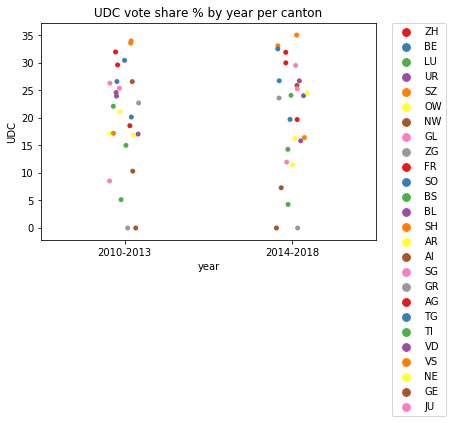

In [136]:
sns.stripplot(x="year",y="UDC",data=voters_all,jitter=True,hue='Code',palette='Set1').set_title('UDC vote share % by year per canton')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

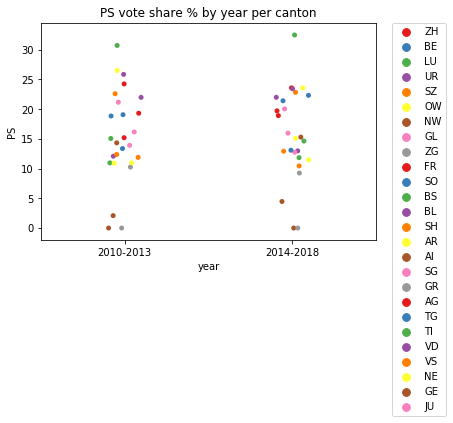

In [137]:
sns.stripplot(x="year",y="PS",data=voters_all,jitter=True,hue='Code',palette='Set1').set_title('PS vote share % by year per canton')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)